# Optic flow analysis

In [1]:
### optic flow dependencies
import os
import numpy as np
import pandas as pd
import xarray as xr
import cv2 as cv
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.backends.backend_pdf import PdfPages
import warnings
warnings.filterwarnings('ignore')
import ray
import matplotlib as mpl
import io_dict_to_hdf5 as ioh5

# Load in worldcam/ephys data and calculate optic flow (currently takes about 3 mins 45 sec)

In [7]:
### set the lags for STAs (in frames, currently 25ms bins)
lag_list = [-2,-1,0,1,2]

### file from elliott with shifter network-corrected worldcam and ephys data (this step takes about a minute currently)
model_data_file = r'\\goeppert\nlab-nas\freely_moving_ephys\optic_flow_data\070921\J553RT\ModelData_dt025_rawWorldCam.h5'
data = ioh5.load(model_data_file)
print('loaded ephys h5 file')

### get shifted worldcam data
wc_data = data['mod_vid_sm_shift']

### calculate optic flow for the entire video
win=5 #window for optic flow calculation (# frames)
fr = wc_data.shape[0]-2 # total number of frames in video (-1 since we're taking the difference between consecutive and -1 for first WC frame being nans)
h = wc_data.shape[1] # image height
w = wc_data.shape[2] # image width
flow_data = np.zeros((fr,h,w,2)) # initialize optic flow array flow_data[frame#,x,y,u/v]

### loop over all frames to get optic flow, populate array
for f in np.arange(1,fr,1):
    flow = cv.calcOpticalFlowFarneback(wc_data[f,:,:],wc_data[f+1,:,:], None, 0.5, 3, win, 3, 5, 1.2, 0)
    flow_data[f,:,:,0] = flow[:,:,0]
    flow_data[f,:,:,1] = flow[:,:,1]

print('finished calculating flow')

##### under construction
### filter on frames when animal is moving forward
# topdown_file = r'C:\Users\nlab\Downloads\070921_J553RT_fm1_topdown.npz'
# topdown_props = np.load(topdown_file)
# good_idxs = topdown_props['running_forward']

##### Elliott's code: Find 'good' timepoints when mouse is active #####
nan_idxs = []
for key in data.keys():
    nan_idxs.append(np.where(np.isnan(data[key]))[0])
good_idxs = np.ones(len(data['model_active']),dtype=bool)
good_idxs[data['model_active']<.5] = False
good_idxs[np.unique(np.hstack(nan_idxs))] = False

good_idxs[0] = False #first worldcam frame is nan
good_idxs[1] = False #first flow frame is nan

data['raw_nsp'] = data['model_nsp'].copy()
##### return only active data #####
for key in data.keys():
    if (key != 'model_nsp') & (key != 'model_active') & (key != 'unit_nums'):
        data[key] = data[key][good_idxs] # interp_nans(data[key]).astype(float)
    elif (key == 'model_nsp'):
        data[key] = data[key][good_idxs]
    elif (key == 'unit_nums'):
        pass

print('found good time points')
##### end Elliott's code #####

### remove stationary periods from worldcam and flow and crop the image to get rid of shiter artifacts
crop_pix = 10 #pixels to crop on each side of the image
wc_data = wc_data[good_idxs,crop_pix:-crop_pix,crop_pix:-crop_pix]
flow_data = np.vstack((np.zeros((2,flow_data.shape[1],flow_data.shape[2],flow_data.shape[3])),flow_data))
flow_data = flow_data[good_idxs,crop_pix:-crop_pix,crop_pix:-crop_pix]
print('removed unwanted time periods from flow data')

#get white noise RFs
wc_data_mnsub = wc_data - np.mean(wc_data,axis=0) #mean subtracted worldcam data
rolled_vid = np.hstack([np.roll(wc_data_mnsub, nframes, axis=0) for nframes in lag_list]) #incorporate the lags
model_vid = rolled_vid.reshape(wc_data.shape[0],-1) #reshape for STA calculation
model_nsp = data['model_nsp'] #ephys data
Ncells = model_nsp.shape[-1] #number of units
goodcells = data['unit_nums'] #indices of good units
sta = (model_vid.T @ model_nsp)/np.sum(model_nsp,0,keepdims=True) #white noise sta
wn_sta = sta.T.reshape((Ncells,len(lag_list)) + wc_data.shape[1:]) #reshaped white noise sta into [unit,x,y]
print('finished calculating white noise STA')

#get sta optic flow amplitude
flow_amp = np.sqrt(flow_data[:,:,:,0]**2 + flow_data[:,:,:,1]**2) #optic flow amp
flow_amp_mn = np.mean(flow_amp,axis=0) #get mean
flow_amp_std = np.std(flow_amp,axis=0) #get std
flow_amp_mnsub = flow_amp.copy() #copy for z-scoring
flow_amp_mnsub -= flow_amp_mn #subtract mean from flow data
flow_amp_mnsub /= flow_amp_std #divide by standard deviation
rolled_vid = np.hstack([np.roll(flow_amp_mnsub, nframes, axis=0) for nframes in lag_list]) #incorporate lags
model_vid = rolled_vid.reshape(flow_amp_mnsub.shape[0],-1) #reshape for sta calculation
sta = (model_vid.T @ model_nsp)/np.sum(model_nsp,0,keepdims=True) #get sta
flow_amp_sta = sta.T.reshape((Ncells,len(lag_list)) + flow_amp_mnsub.shape[1:]) #reshape flow amp sta into [unit,lag,x,y]
print('finished calculating flow amp STA')

#get sta optic flow vectors
flow_mn = np.mean(flow_data,axis=0) #calculate flow mean
flow_std = np.std(flow_data,axis=0) #calculate flow std
flow_data_mnsub = flow_data.copy() #copy flow data to be z-scored
flow_data_mnsub -= flow_mn #subtract mean from flow data
flow_data_mnsub /= flow_std #divide by standard deviation
rolled_vid = np.hstack([np.roll(flow_data_mnsub, nframes, axis=0) for nframes in lag_list]) #incorporate lags
model_vid = rolled_vid.reshape(flow_data_mnsub.shape[0],-1) #reshape flow data for sta
sta = (model_vid.T @ model_nsp)/np.sum(model_nsp,0,keepdims=True) #calculate flow sta
flow_sta = sta.T.reshape((Ncells,len(lag_list)) + flow_data_mnsub.shape[1:]) #reshape flow sta into [unit,lag,x,y,U/V]
print('finished calculating flow STA')

### insert code to save flow_amp_sta and flow_sta


loaded ephys h5 file
finished calculating flow


IndexError: boolean index did not match indexed array along dimension 0; dimension is 108707 but corresponding boolean dimension is 163054

# Plot optic flow RFs (currently takes about 40 sec)

In [5]:
### calculate avg firing rates for plotting
avg_rates = np.round((1/0.025)*np.sum(model_nsp,axis=0)/model_nsp.shape[0],1)

### create a meshgrid to plot flow vectors downsampled
h = flow_data.shape[1]
w = flow_data.shape[2]
X,Y = np.meshgrid(np.arange(0,w),np.arange(0,h))

nx=5 #binning for plotting flow vectors

vmin=-0.25 #scaling for wn and flow amp STAs
vmax=0.25

### make PDF to plot results
pdf_file = r'T:/freely_moving_ephys/%s_flowSTAs_bin%dX_win%d_zscoreflow_movingforward.pdf' % (os.path.split(model_data_file)[-1][:-4],nx,win)
pp = PdfPages(pdf_file)

### plot the mean worldcam image with mean flow vector overlaid
fig, axs = plt.subplots(1,2,figsize=(10,5))
ax = axs[0]
ax.imshow(np.mean(wc_data,axis=0),cmap='gray')
sta = flow_mn
U = sta[:,:,0]
V = sta[:,:,1]
scale = 10*np.max(np.sqrt(U**2 + V**2))
ax.quiver(X[::nx,::nx],Y[::nx,::nx],U[::nx,::nx],-V[::nx,::nx],scale=scale)
ax.set_title('mean worldcam/optic flow')
ax.axis('off')
### plot the std worldcam image with std flow vector overlaid
ax = axs[1]
ax.imshow(np.std(wc_data,axis=0),cmap='gray')
sta = flow_std
U = sta[:,:,0]
V = sta[:,:,1]
scale = 10*np.max(np.sqrt(U**2 + V**2))
ax.quiver(X[::nx,::nx],Y[::nx,::nx],U[::nx,::nx],-V[::nx,::nx],scale=scale)
ax.set_title('std worldcam/optic flow')
ax.axis('off')
fig.tight_layout()
### save the figure
pp.savefig(fig)
plt.close(fig)

### calculate a scale for plotting optic flow vectors by taking max of flow across units/lags
scale = np.zeros((len(goodcells),len(lag_list)))
for l,lag in enumerate(lag_list):
    for c,ind in enumerate(goodcells):
        sta = flow_sta[c,l,:,:,:]
        U = sta[:,:,0].flatten()
        V = sta[:,:,1].flatten()
        scale[c,l] = np.max(np.sqrt(U**2 + V**2))
scale = np.max(scale.flatten())

### plot the optic flow vectors across lags for each cell in a separate figure
for c, (ind,spikes) in enumerate(zip(goodcells,avg_rates)):
    fig, axs = plt.subplots(2,len(lag_list)+1,figsize=(3*(len(lag_list)+1),3))
    
    ### turn off axes on blank panel
    ax = axs[1,0]
    ax.axis('off')

    ax = axs[0,0]
    ### plot the cell's white noise RF first
    ax.imshow(wn_sta[c,2,:,:],vmin=vmin,vmax=vmax,cmap='jet') #plot white noise sta
    ax.set_title('unit %d(%d) %0.1fHz avg' % (c,ind,spikes),fontsize=10)
    ax.axis('off')
    ax.axis('equal')
    
    ### cycle through lags and plot flow vectors and amps
    for l,lag in enumerate(lag_list):
        ax = axs[0,l+1]
        sta = flow_sta[c,l,:,:,:]
        U = sta[:,:,0]
        V = sta[:,:,1]
        ax.quiver(X[::nx,::nx],-Y[::nx,::nx],U[::nx,::nx],-V[::nx,::nx],scale=scale)
        ax.axis('off')
        ax.axis('equal')
        ax.set_title('lag %dms' % (lag*25),fontsize=10)

        ax = axs[1,l+1]
        sta = flow_amp_sta[c,l,:,:]
        ax.imshow(sta,vmin=vmin,vmax=vmax,cmap='jet') #plot white noise sta
        ax.axis('off')
        ax.axis('equal')

    ### add flow vectors to white noise RF plot
    ax = axs[0,0]
    sta = flow_sta[c,np.where(np.array(lag_list)==0)[0][0],:,:,:]
    U = sta[:,:,0]
    V = sta[:,:,1]
    ax.quiver(X[::nx,::nx],Y[::nx,::nx],U[::nx,::nx],-V[::nx,::nx],scale=scale)
    fig.tight_layout()
    
    ### save the figure to pdf
    pp.savefig(fig)
    plt.close(fig)

### close the pdf
pp.close()

In [17]:
np.where(np.isnan(topdown_props['top_speed']))[0].shape

(5191,)

## Exploring flow properties

0.0011137878441598468


Text(0.5, 1.0, 'mean of flow data')

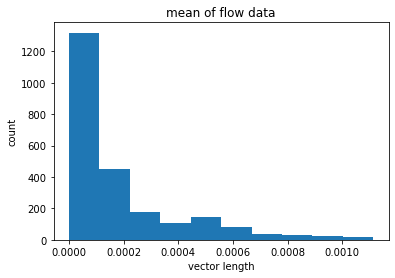

In [65]:
### histogram of mean vector lengths
sta = np.nanmean(flow_data,axis=0)
U = sta[:,:,0][:]
V = sta[:,:,1][:]
plt.hist(np.reshape(np.sqrt(U**2 + V**2),-1))
plt.xlabel('vector length')
plt.ylabel('count')
plt.title('mean of flow data')

Text(0.5, 1.0, 'std of flow data')

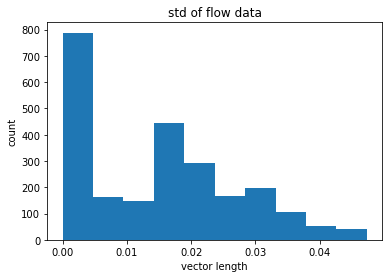

In [68]:
### histogram of std vector lengths
sta = np.nanstd(flow_data,axis=0)
U = sta[:,:,0][:]
V = sta[:,:,1][:]

plt.hist(np.reshape(np.sqrt(U**2 + V**2),-1))
plt.xlabel('vector length')
plt.ylabel('count')
plt.title('std of flow data')

Text(0.5, 1.0, 'mean world image, mean flow vectors, std as ellipses')

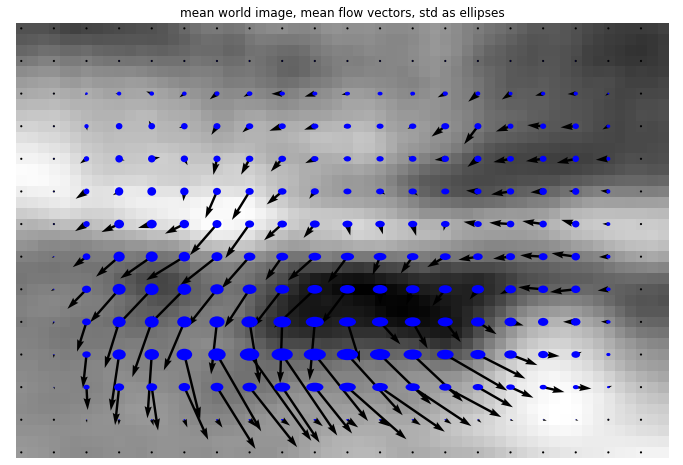

In [119]:
### plot the std as a set of ellipses, where width is proportional to u and height to v
fig, ax = plt.subplots(1,1,figsize=(12,8))
ax.imshow(np.mean(wc_data,axis=0),cmap='gray')
ells=[]
# scale = 5*np.max(np.sqrt(U**2 + V**2))
nx=3
scale = 50
sta = np.nanstd(flow_data,axis=0)
U = sta[:,:,0]
V = sta[:,:,1]
for x,y,u,v in zip(X[::nx,::nx].flatten(),Y[::nx,::nx].flatten(),U[::nx,::nx].flatten(),V[::nx,::nx].flatten()):
    ells.append(Ellipse(xy=(x,y),height=v*scale,width=u*scale))
for e in ells:
    ax.add_artist(e)
    e.set_clip_box(ax.bbox)
    e.set_alpha(1)
    e.set_facecolor('b')

sta = flow_mn
U = sta[:,:,0]
V = sta[:,:,1]
scale = 6*np.max(np.sqrt(U**2 + V**2))
ax.quiver(X[::nx,::nx],Y[::nx,::nx],U[::nx,::nx],-V[::nx,::nx],scale=scale)

ax.axis('off')
ax.axis('equal')
ax.set_title('mean world image, mean flow vectors, std as ellipses')

# Make a video clip of optic flow overlaid on shifted video

In [37]:
### 
ray.init(ignore_reinit_error=True)
t=100
nx = 5
scale = 0.25
vm = 5

@ray.remote
def plot_optic_flow_movie(wc_data,flow_data,flow_amp,t,nx,scale):
    fig, axs = plt.subplots(1,2,figsize=(10,3))

    ax = axs[0]
    ax.imshow(wc_data[t,:,:],cmap='gray')
    ax.set_title('shifter network-corrected image w/optic flow vectors',fontsize=8)
    ax.axis('off')
    ax.axis('equal')

    # ax = axs[1]
    X,Y = np.meshgrid(np.arange(0,wc_data.shape[2]),np.arange(0,wc_data.shape[1]))
    U = flow_data[t,:,:,0]
    V = flow_data[t,:,:,1]
    ax.quiver(X[::nx,::nx],Y[::nx,::nx],U[::nx,::nx],-V[::nx,::nx],scale=scale,color='r')
    # ax.axis('off')
    # ax.axis('equal')

    ax = axs[1]
    ax.imshow(flow_amp[t,:,:],vmin=-vm,vmax=vm,cmap='jet')
    ax.set_title('pixel-wise optic flow amplitude',fontsize=8)
    ax.axis('off')
    ax.axis('equal')

    fig.tight_layout()

    width, height = fig.get_size_inches() * fig.get_dpi()
    fig.canvas.draw()       # draw the canvas, cache the renderer
    images = np.frombuffer(fig.canvas.tostring_rgb(),
                        dtype='uint8').reshape(int(height), int(width), 3)
    
    plt.close(fig)
    
    return images

mpl.use('agg')

# start = time.time()
##### initialize time points for animation and progressbar #####
st_frame = 10000
t = st_frame
dt = 10*50 #sec * fps
time_range = np.arange(t,t+dt)
# num_ticks = np.size(time_range)
# pb = ProgressBar(num_ticks)
# actor = pb.actor

##### Put large arrays into shared memory #####
time_range_r = ray.put(time_range)
wc_data_r = ray.put(wc_data)
flow_data_r = ray.put(flow_data)
flow_amp_r = ray.put(flow_amp_mnsub)

##### Loop over parameters appending process ids #####
result_ids = []
for t in time_range:
    result_ids.append(plot_optic_flow_movie.remote(wc_data_r,flow_data_r,flow_amp_r,t,nx,scale))

##### pring progressbar and get results #####
# pb.print_until_done()
results_p = ray.get(result_ids)
images = np.stack([results_p[i] for i in range(len(results_p))])

##### Make video with opencv #####
aniname = 'optic_flow_test_stfr%d.mp4' % st_frame
vid_name = r'T:/freely_moving_ephys/' + aniname
frame_dt = 0.025
t_down = 4
FPS = int(1/(frame_dt*t_down))
out = cv.VideoWriter(vid_name, cv.VideoWriter_fourcc(*'mp4v'), FPS, (images.shape[-2], images.shape[-3]))

for fm in range(images.shape[0]):
    out.write(cv.cvtColor(images[fm], cv.COLOR_BGR2RGB))
out.release()
# print('Making Animation {}: {}'.format(aniname, time.time()-start))
# del results_p, time_range_r, model_vid_sm_r, model_gz_r, model_th_r, model_phi_r, pb
# gc.collect()


2021-12-07 21:49:01,039	INFO worker.py:833 -- Calling ray.init() again after it has already been called.


# Make PDF of flow

In [174]:
### plot some example flow data in a pdf

nrows = 3 # to show raw, difference, and optic flow
ncols = 10 # number of example frames to plot
fig_scale=3 # how big to blow up the figure

# st_frame = 1000 #animal moves a bit
st_frame = 10000 #monitor view

nx=5 #downsample factor
scale=0.25
win=15

### initialize the figure
fig, axs = plt.subplots(nrows,ncols,figsize=(ncols*fig_scale,nrows*fig_scale))

### initialize the pdf
pdf_file = r'T:/freely_moving_ephys/%s_frame%d_bin%dX_win%d_scale%0.2f.pdf' % (os.path.split(vid_file)[-1][:-4],st_frame,nx,win,scale)
pp = PdfPages(pdf_file)

### loop through example frames, get flow, and plot everything
for f,fr in enumerate(np.arange(st_frame,st_frame+ncols,1)):

    prvs = wc_data[fr,:,:] # current frame
    next = wc_data[fr+1,:,:] # next frame

    w = prvs.shape[0]
    h = prvs.shape[1]
    X,Y = np.meshgrid(np.arange(0,h),np.arange(0,w))

    flow = cv.calcOpticalFlowFarneback(prvs,next, None, 0.5, 3, win, 3, 5, 1.2, 0) #(prvs,next, None, 0.5, 3, 3, 15, 5, 1.2, 0)
    # mag, ang = cv.cartToPolar(flow[...,0], flow[...,1])

    ### plot raw frame
    ax = axs[0,f]
    im = ax.imshow(prvs,cmap='gray',vmin=-2.5,vmax=2.5)
    ax.axis('off')

    ### plot raw difference
    ax = axs[1,f]
    im2 = ax.imshow(next-prvs,cmap='jet',vmin=-2.5,vmax=2.5)
    ax.axis('off')

    ### plot optic flow
    ax = axs[2,f]
    U = flow[:,:,0]
    V = flow[:,:,1]
    ax.quiver(X[::nx,::nx],Y[::nx,::nx],U[::nx,::nx],-V[::nx,::nx],scale=scale)
    ax.axis('off')

### make colorbar for raw data
ax = axs[0,f]   
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

### make colorbar for raw difference
ax = axs[1,f]   
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im2, cax=cax)

### save figure to pdf and close both
pp.savefig(fig)
plt.close(fig)
pp.close()

print('finished making PDF!')

finished making PDF!


# Group eye movement analysis

In [109]:
### dependencies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import warnings
warnings.filterwarnings('ignore')

### functions

def xy_axis(ax):
    
    ### Removes the top and right bounding axes that are plotted by default in matplotlib
    
    ### INPUTS
    ### ax: axis object (e.g. from fig,ax = plt.subplots(1,1))
    
    ### OUTPUTS
    ### ax: the same axis w/top and right lines removed
    
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    return ax

print('finished loading dependencies')

def plot_group_eye_head_traces(df,sacs,mov_type,eye_head,baselines,baseline_pts,trace_range,trange,save_pdf,pp,sup):
    
    ### plots clustered traces of spiking vs. eye/head movements and saves a pdf (optional)
    
    ### INPUTS
    ### recs: list of recordings names, e.g. ['fm1']
    ### sacs: list of saccade labels, e.g. ['upsacc','downsacc']
    ### mov_type: list of movement types, e.g. ['gaze_shift','comp']
    ### eye_head: list of eye/head movement labels, e.g. ['dEye','dHead']
    ### trace_range: time range you want to plot over, e.g. [-0.25,0.5]
    ### trange: time points for traces, current is np.arange(-1,1.1-0.025,0.025)
    ### baselines: list of booleans if you want to baseline traces or not, e.g. [True,False]
    ### baseline_pts: indices to use for baseline subtraction, e.g. np.arange(20,36)
    ### save_pdf: boolean value for if you want to save a pdf, e.g. True
    
    ### OUTPUTS
    ### currently none
    
    for rec in recs:
        for eh in eye_head:
            for baseline in baselines:
                fig, axs = plt.subplots(len(mov_type),len(sacs),figsize=(5*len(sacs),5*len(mov_type)))
                for m,m_t in enumerate(mov_type):
                    for s,sac in enumerate(sacs):
                        trace_label = '%s_%s_avg_%s_%s' % (rec,sac,m_t,eh)
                        cluster = trace_label + '_cluster'
#                         cluster = 'fm1_upsacc_avg_gaze_shift_dEye_cluster' #% (eh)
                        clusts = np.unique(df[cluster])
                        len_trace = len(df[trace_label].iloc[-1])

                        for clust in clusts:
                            clust_df = df[df[cluster]==clust]
                            clust_df.reset_index(inplace=True,drop=True)
#                             cluster_label = clust_df[cluster + '_type'].iloc[0]
                            sessions = np.unique(clust_df['session'])
                            num_sess = len(np.unique(clust_df['session']))
                            all_sess = np.zeros((num_sess,len_trace))
                            for se,sess in enumerate(sessions):
                                sess_df = clust_df[clust_df['session']==sess]
                                if len(sess_df)>0:
                                    sess_df.reset_index(inplace=True,drop=True)
                                    sess_array = np.zeros((len(sess_df),len_trace))
                                    for t,trace in enumerate(sess_df[trace_label]):
                                        sess_array[t,:] = trace
                                    all_sess[se,:] = np.nanmean(sess_array,axis=0)
                                else:
                                    sess_array = np.empty(len_trace)
                                    sess_array[:] = np.nan
                                    all_sess[se,:] = sess_array

                            ax = axs[m,s]
                            x = trange
                            y=np.nanmean(all_sess,axis=0)
                            if baseline:
                                y-=np.nanmean(y[baseline_pts])
                            err = np.nanstd(all_sess,axis=0)/np.sqrt(num_sess)

                            ax.plot(x,y,'-',label=str(clust))
                            ax.fill_between(x,y-err,y+err,alpha=0.2)
                        ax.set_xlabel('time from movement (s)')
                        ax.set_title(trace_label)
                        ax.set_xlim(trace_range[0],trace_range[1])
                        if baseline:
                            ax.set_ylim(-15,15)
                            ax.set_ylabel('baselined sp/s')
                        else:
                            ax.set_ylim(0,40)
                            ax.set_ylabel('sp/s')
                        ax = xy_axis(ax)
                        ax.legend(fontsize=8)
                fig.tight_layout()
                if save_pdf:
                    pp.savefig(fig)
                    plt.close(fig)

    print('finished adding eye/head plots to PDF!')

finished loading dependencies


# Load the data

In [11]:
group_file = r'\\Goeppert\nlab-nas\freely_moving_ephys\batch_files\092221\pooled_ephys_population_update_092221.pickle'
df = pd.read_pickle(group_file)

# remove inserted column if it exists
try:
    del df['level_0']
except:
    pass

# set up PDF

In [110]:
pdf_file = r'T:/freely_moving_ephys/group_analysis_cluster.pdf'
pp = PdfPages(pdf_file)

# Plot firing rate around eye/head movements for all sessions

In [111]:
recs = ['fm1'] #list of recording names
sacs = ['upsacc','downsacc'] #list of saccade names
mov_type = ['gaze_shift','comp'] #list of movement types
eye_head = ['dEye','dHead'] #list of eye/head variables
trace_range = [-0.25,0.5] #time range to plot traces over
trange = np.arange(-1,1.1-0.025,0.025) #time points for traces
baselines=[True,False] #do you want to baseline or do not or do both
baseline_pts = np.arange(20,36) #indices for baselining
save_pdf=True #do you want to save pdf
sup = 'grouped by own cluster'
plot_group_eye_head_traces(df,sacs,mov_type,eye_head,baselines,baseline_pts,trace_range,trange,save_pdf,pp,sup)

finished adding eye/head plots to PDF!


# Close the PDF

In [112]:
pp.close()

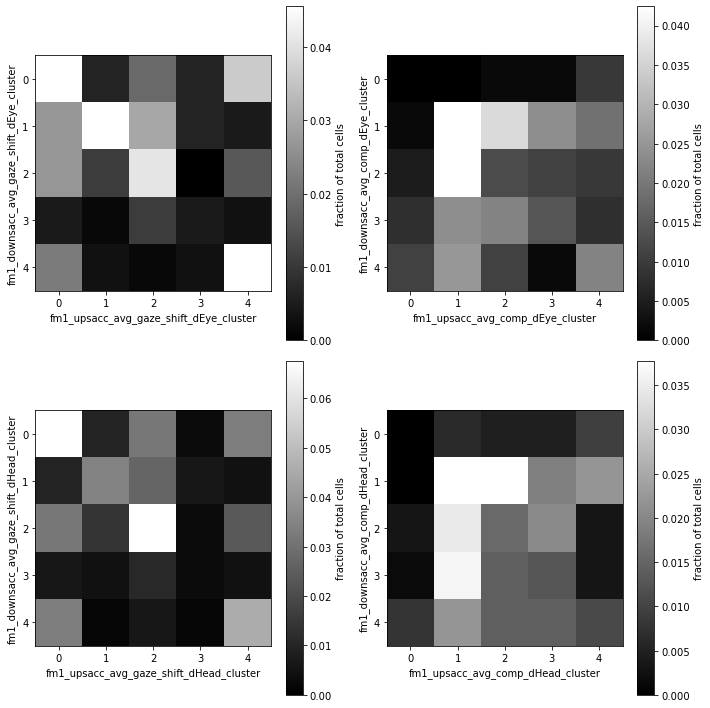

In [60]:
rec = 'fm1'
fig, axs = plt.subplots(2,2,figsize=(10,10))
axs=axs.ravel()
cnt=0
for eh in eye_head:
    for m,m_t in enumerate(mov_type):
        
        up_clust = 'fm1_upsacc_avg_%s_%s_cluster' % (m_t,eh)
        down_clust = 'fm1_downsacc_avg_%s_%s_cluster' % (m_t,eh)
        
        delta_array = np.zeros([5,5])
        for index,row in df.iterrows():
            up_ind = int(row[up_clust])
            down_ind = int(row[down_clust])
            delta_array[up_ind,down_ind] = delta_array[up_ind,down_ind] + 1
        delta_array /= len(df)
        
        da = delta_array.copy()
        idx = np.unravel_index(np.argmax(da), da.shape)
        da[idx[0],idx[1]]=0
        
        ax = axs[cnt]
        pos = ax.imshow(delta_array,cmap='gray',vmin=0,vmax=np.amax(da))
        ax.set_xlabel(up_clust)
        ax.set_ylabel(down_clust)
        cbar = plt.colorbar(pos,ax=ax)
        cbar.set_label('fraction of total cells')
        
        cnt+=1
fig.tight_layout()

In [81]:
df.shape

(636, 530)

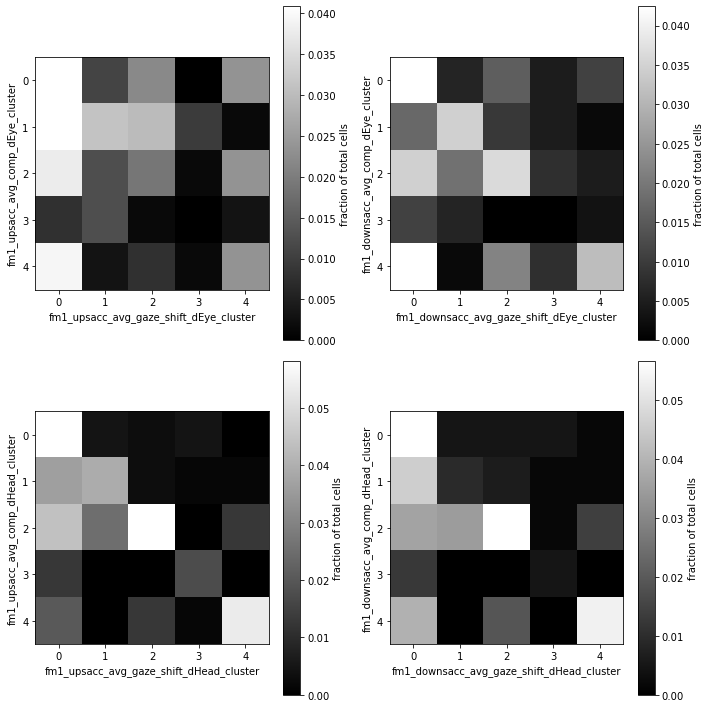

In [82]:
rec = 'fm1'
fig, axs = plt.subplots(2,2,figsize=(10,10))
axs=axs.ravel()
cnt=0
comp_remap = [3.,0.,2.,4.,1.]
for eh in eye_head:
    for s,sac in enumerate(sacs):
        
        up_clust = 'fm1_%s_avg_gaze_shift_%s_cluster' % (sac,eh)
        down_clust = 'fm1_%s_avg_comp_%s_cluster' % (sac,eh)
        
        
        comp_remap_type = []
        for index,row in df.iterrows():
            comp_remap_type.append(comp_remap[int(row[down_clust])])
            
        df['comp_remap_type'] = comp_remap_type
        
        delta_array = np.zeros([5,5])
        for index,row in df.iterrows():
            up_ind = int(row[up_clust])
            down_ind = int(row['comp_remap_type'])
            delta_array[up_ind,down_ind] = delta_array[up_ind,down_ind] + 1
        delta_array /= len(df)
        
        da = delta_array.copy()
        idx = np.unravel_index(np.argmax(da), da.shape)
        da[idx[0],idx[1]]=0
        
        ax = axs[cnt]
        pos = ax.imshow(delta_array,cmap='gray',vmin=0,vmax=np.amax(da))
        ax.set_xlabel(up_clust)
        ax.set_ylabel(down_clust)
        cbar = plt.colorbar(pos,ax=ax)
        cbar.set_label('fraction of total cells')
        
        cnt+=1
fig.tight_layout()

In [101]:
delta_array

array([[0.64779874, 0.00471698, 0.00471698, 0.00471698, 0.00157233],
       [0.04559748, 0.00943396, 0.00628931, 0.00157233, 0.00157233],
       [0.03616352, 0.03459119, 0.05660377, 0.00157233, 0.01415094],
       [0.01257862, 0.        , 0.        , 0.00471698, 0.        ],
       [0.03930818, 0.        , 0.01886792, 0.        , 0.05345912]])

In [76]:
up_clust = 'fm1_%s_avg_gaze_shift_%s_cluster_type' % (sac,eh)
down_clust = 'fm1_%s_avg_comp_%s_cluster_type' % (sac,eh)

In [77]:
np.unique(df[up_clust])

array(['biphasic', 'early', 'late', 'negative', 'unresponsive'],
      dtype=object)

In [ ]:
#gaze
#0 = unresponsive
#1 = biphasic
#2 = late
#3 = negative
#4 = early

#comp
#0 = negative
#1 = unresponsive
#2 = late
#3 = early
#4 = biphasic

comp_remap = [3,0,2,4,1]
comp_remap_type = []
for index,row in df.iterrows():
    comp_remap_type.append(comp_remap[row[down_clust]])

In [75]:
df.columns.values

array(['index', 'Amplitude', 'ContamPct', 'KSLabel', 'amp', 'ch', 'depth',
       'fr', 'group', 'fm1_n_spikes', 'sh', 'waveform', 'fm1_spikeT',
       't0', 'fm1_spikeTraw', 'fm1_rate', 'fm1_c_range', 'fm1_crf_cent',
       'fm1_crf_tuning', 'fm1_crf_err', 'fm1_spike_triggered_average',
       'fm1_sta_shape', 'fm1_spike_triggered_variance', 'fm1_upsacc_avg',
       'fm1_downsacc_avg', 'fm1_upsacc_avg_gaze_shift_dEye',
       'fm1_downsacc_avg_gaze_shift_dEye', 'fm1_upsacc_avg_comp_dEye',
       'fm1_downsacc_avg_comp_dEye', 'fm1_upsacc_avg_gaze_shift_dHead',
       'fm1_downsacc_avg_gaze_shift_dHead', 'fm1_upsacc_avg_comp_dHead',
       'fm1_downsacc_avg_comp_dHead',
       'fm1_spike_rate_vs_pupil_radius_cent',
       'fm1_spike_rate_vs_pupil_radius_tuning',
       'fm1_spike_rate_vs_pupil_radius_err',
       'fm1_spike_rate_vs_theta_cent', 'fm1_spike_rate_vs_theta_tuning',
       'fm1_spike_rate_vs_theta_err', 'fm1_spike_rate_vs_gz_cent',
       'fm1_spike_rate_vs_gz_tuning', 'fm1_